In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, LabelEncoder #LabelEncoder faulty
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import joblib

## Import Dataset

In [17]:
file_path = "MIT-BIH Arrhythmia Database.csv"
df = pd.read_csv(file_path)
print("Selected File:", file_path)
df.head(), df['type'].value_counts()

Selected File: MIT-BIH Arrhythmia Database.csv


(   record type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
 0     101    N        76        313  0.074347 -0.160548  1.036401 -0.285662   
 1     101    N       313        315 -0.052079 -0.264784  0.886597 -0.366298   
 2     101    N       315        321 -0.062151 -0.296983  0.991859 -0.410306   
 3     101    N       321        336 -0.063322 -0.281386  1.034903 -0.403880   
 4     101    N       336        344 -0.062915  1.046914  1.046408  1.046408   
 
     0_qPeak  0_qrs_interval  ...   1_qPeak  1_qrs_interval  1_pq_interval  \
 0 -0.026824              41  ...  0.025930               2             18   
 1 -0.059710              21  ... -0.042009              26             27   
 2 -0.065686              22  ...  0.009528               3              8   
 3 -0.071750              22  ... -0.020536               6              9   
 4 -0.074639              11  ...  0.016053              16              5   
 
    1_qt_interval  1_st_interval  1_qrs_morph0  

## Test Dataset Generation

In [18]:
# Set random seed
seed = 42

# Sample from each class (10000 rows)
n_sample = df[df["type"] == "N"].sample(n = 5000, random_state = seed)
veb_sample = df[df["type"] == "VEB"].sample(n = 2500, random_state = seed)
sveb_sample = df[df["type"] == "SVEB"].sample(n = 2500, random_state = seed)

# Combine into balanced subset
df_balanced = pd.concat([n_sample, veb_sample, sveb_sample]).sample(frac = 1, random_state = seed).reset_index(drop = True)

# Check new class dist
df_balanced['type'].value_counts()

,count
type,
N,5000
VEB,2500
SVEB,2500


In [19]:
# save as .csv
# output_path = "balanced_dataset.csv" #1
output_path = "balanced_dataset1.csv"
df_balanced.to_csv(output_path, index = False)

print("Uploading", output_path, "to session path...")

Uploading balanced_dataset1.csv to session path...


In [20]:
# change our original dataset to balanced one
df = df_balanced.copy()
print("Ensure copy is correct...")
df['type'].value_counts()

Ensure copy is correct...


,count
type,
N,5000
VEB,2500
SVEB,2500


## Pytorch Setup

In [21]:
# Encode target labels into Numeric values (for categorical)
df = df[df['type'].isin(['N', 'VEB', 'SVEB'])].copy() # filter only 3 classes
# df['type'] = (
#     df['type']
#     .replace({'N': 0, 'VEB': 1, 'SVEB': 2})
#     .infer_objects(copy=False)
#     .astype(int)
#  ) # change into numeric values

df['type'] = df['type'].astype(str).replace({'N': 0, 'VEB': 1, 'SVEB': 2}).astype(int)

/tmp/ipython-input-21-1305892798.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type'] = df['type'].astype(str).replace({'N': 0, 'VEB': 1, 'SVEB': 2}).astype(int)


In [22]:
# Split features and labels
X = df.drop(columns=["record", "type"])  #independent features
y = df["type"] #target column

In [43]:
# Standardizing features - mean = 0, SD = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl") #save StandardScaler for the predictor - call with "scaler = joblib.load("scaler.pkl")"

['scaler.pkl']

In [44]:
# Stratified training, validation, and testing splits to preserve class balance | 80% training, 10% validation, 10% testing
# First split: Train vs. Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Second split: Validation vs. Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [45]:
# Converting splits into tensors with correct dtypes
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
print("Shape of Training Tensor (Attributes):\n", X_train_tensor.shape, "\nShape of Training Tensor (Targets):\n", y_train_tensor.shape)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
print("\nShape of Validation Tensor (Attributes):\n", X_val_tensor.shape, "\nShape of Validation Tensor (Targets):\n", y_val_tensor.shape)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
print("\nShape of Testing Tensor (Attributes):\n", X_test_tensor.shape, "\nShape of Testing Tensor (Targets):\n", y_test_tensor.shape)

Shape of Training Tensor (Attributes):
 torch.Size([8000, 32]) 
Shape of Training Tensor (Targets):
 torch.Size([8000])

Shape of Validation Tensor (Attributes):
 torch.Size([1000, 32]) 
Shape of Validation Tensor (Targets):
 torch.Size([1000])

Shape of Testing Tensor (Attributes):
 torch.Size([1000, 32]) 
Shape of Testing Tensor (Targets):
 torch.Size([1000])


In [46]:
# Wrap data into a dataset + dataloader (torch.utils) - Modify batch_size
# batch_size = 64
# batch_size = 128
# batch_size = 256
batch_size = 512 #attempt to reduce noise

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size)

In [47]:
#Sanity check: confirm input dimensions match tensors
input_dim = X_train_tensor.shape[1]
print("Dimensions of Input (should be 32):", input_dim)

Dimensions of Input (should be 32): 32


# **MLP** **Modeling**

## **Model 1 (2 hidden layers)**

- Architecture of Model 1:
  - Input layer
  - 2 Hidden layers (each hidden units with ReLU activation)
    - First hidden layer: 128 units
    - Second hidden layer: 64 units
  - Output layers (3)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # 1st hidden layer - nn.Linear(32, 128
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1) # 2nd hidden layer - nn.Linear(128, 64)
        self.fc3 = nn.Linear(hidden_dim1, output_dim) # output layer - nn.Linear(64, 3)

    def forward(self, x): # Forward Pass of the network
        x = F.relu(self.fc1(x)) # Activation after 1st hidden layer
        x = F.relu(self.fc2(x)) # Activation after 2nd hidden layer
        return self.fc3(x) # Final output

# Creating MLP model with 32 input features, 2 hidden layers, and 3 output classes
model = MLP(input_dim = 32, hidden_dim = 128, hidden_dim1 = 64, output_dim = 3)

### Training

In [49]:
# UNCOMMENT IF TRAINING ON GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) #cuda = gpu
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer for setting learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001) #attempt to reduce noise

# Training epochs
# epochs = 100
epochs = 1000 #attempt to reduce noise

# Storing loss and accuracy at each epoch in list
losses = []
val_accuracies = []

for i in range(epochs):

    # --- TRAINING ---
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass + optimization
    loss.backward()
    optimizer.step()

    # Record loss
    losses.append(loss.item())

    # --- VALIDATION ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_pred_labels = torch.argmax(val_pred, dim=1)
        correct = (val_pred_labels == y_val_tensor).sum().item()
        val_accuracy = correct / y_val_tensor.size(0)
        val_accuracies.append(val_accuracy)

    # Logging every 10 epochs
    if i % 100 == 0 or i == epochs - 1:
        print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

Using device: cuda
Epoch 1/1000, Train Loss: 1.0894, Val Accuracy: 0.3360
Epoch 101/1000, Train Loss: 0.8628, Val Accuracy: 0.7260
Epoch 201/1000, Train Loss: 0.6113, Val Accuracy: 0.7770
Epoch 301/1000, Train Loss: 0.4574, Val Accuracy: 0.8200
Epoch 401/1000, Train Loss: 0.3723, Val Accuracy: 0.8390
Epoch 501/1000, Train Loss: 0.3190, Val Accuracy: 0.8790
Epoch 601/1000, Train Loss: 0.2801, Val Accuracy: 0.9030
Epoch 701/1000, Train Loss: 0.2503, Val Accuracy: 0.9150
Epoch 801/1000, Train Loss: 0.2267, Val Accuracy: 0.9280
Epoch 901/1000, Train Loss: 0.2068, Val Accuracy: 0.9370
Epoch 1000/1000, Train Loss: 0.1899, Val Accuracy: 0.9440


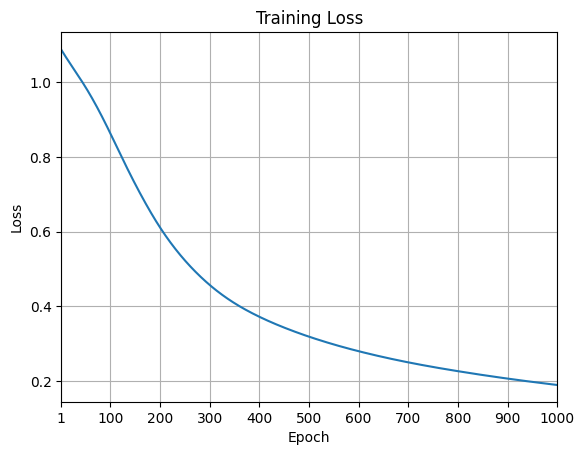

In [50]:
# Visualization of training loss over epochs
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.xticks([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(1, 1000)
plt.grid()
plt.show()

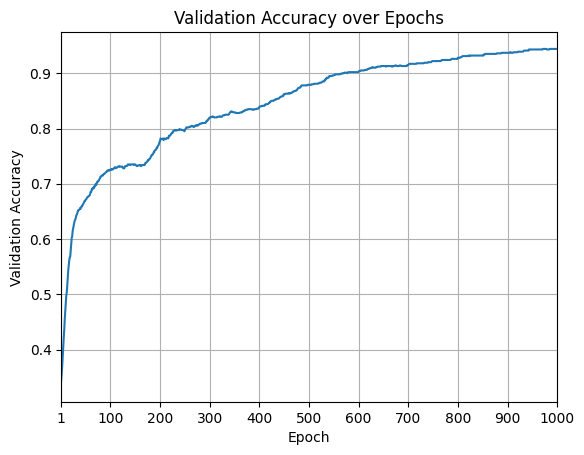

In [51]:
#Visualization of validation accuracy over epochs
plt.plot(range(epochs), val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xticks([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(1, 1000)
plt.grid()
plt.show()

## Evaluation

In [52]:
# Classification Report
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred_test, dim=1)

# OUTPUT FOR CPU TESTING
# print("Classification Report:\n")
# print(classification_report(y_test_tensor.numpy(), y_pred_labels.numpy(), target_names=["N", "VEB", "SVEB"]))

# OUTPUT FOR GPU TESTING
print("Classification Report:\n")
print(classification_report(
    y_test_tensor.cpu().numpy(),  # move to CPU before .numpy()
    y_pred_labels.cpu().numpy(),  # move to CPU before .numpy()
    target_names=["N", "VEB", "SVEB"]
))

Classification Report:

              precision    recall  f1-score   support

           N       0.95      0.95      0.95       500
         VEB       0.95      0.94      0.95       250
        SVEB       0.90      0.90      0.90       250

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



In [53]:
# Accuracy
accuracy = (y_pred_labels == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9380


## **Model 2 (3 hidden layers)**

- Architecture of Model 2:
  - Input layer
  - 3 Hidden layers (each hidden units with ReLU activation)
    - First hidden layer: 128 units
    - Second hidden layer: 128 units
    - Third hidden layer: 64 units
  - Output layers

In [54]:
# import torch.nn as nn
# import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) # 1st hidden layer - nn.Linear(32, 128)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim1) # 2nd hidden layer - n.Linear(128, 128)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2) # 3rd hidden layer - nn.Linear(128, 64)
        self.fc4 = nn.Linear(hidden_dim2, output_dim) # output layer - nn.linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Activation after 1st hidden layer
        x = F.relu(self.fc2(x)) # Activation after 2nd hidden layer
        x = F.relu(self.fc3(x)) # Activation after 3rd hidden layer
        return self.fc4(x)

model = MLP(input_dim = 32, hidden_dim = 128, hidden_dim1 = 128, hidden_dim2 = 64, output_dim = 3)

### Training

In [55]:
# UNCOMMENT IF TRAINING ON GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) #cuda = gpu
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer for setting learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001) #attempt to reduce noise

# Training epochs
# epochs = 100
epochs = 1000 #attempt to reduce noise

# Storing loss and accuracy at each epoch in list
losses = []
val_accuracies = []

for i in range(epochs):

    # --- TRAINING ---
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass + optimization
    loss.backward()
    optimizer.step()

    # Record loss
    losses.append(loss.item())

    # --- VALIDATION ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_pred_labels = torch.argmax(val_pred, dim=1)
        correct = (val_pred_labels == y_val_tensor).sum().item()
        val_accuracy = correct / y_val_tensor.size(0)
        val_accuracies.append(val_accuracy)

    # Logging every 10 epochs
    if i % 100 == 0 or i == epochs - 1:
        print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

Using device: cuda
Epoch 1/1000, Train Loss: 1.1007, Val Accuracy: 0.4660
Epoch 101/1000, Train Loss: 0.8234, Val Accuracy: 0.6780
Epoch 201/1000, Train Loss: 0.4616, Val Accuracy: 0.8290
Epoch 301/1000, Train Loss: 0.3151, Val Accuracy: 0.8800
Epoch 401/1000, Train Loss: 0.2489, Val Accuracy: 0.9180
Epoch 501/1000, Train Loss: 0.2064, Val Accuracy: 0.9390
Epoch 601/1000, Train Loss: 0.1744, Val Accuracy: 0.9460
Epoch 701/1000, Train Loss: 0.1493, Val Accuracy: 0.9510
Epoch 801/1000, Train Loss: 0.1289, Val Accuracy: 0.9520
Epoch 901/1000, Train Loss: 0.1112, Val Accuracy: 0.9530
Epoch 1000/1000, Train Loss: 0.0956, Val Accuracy: 0.9560


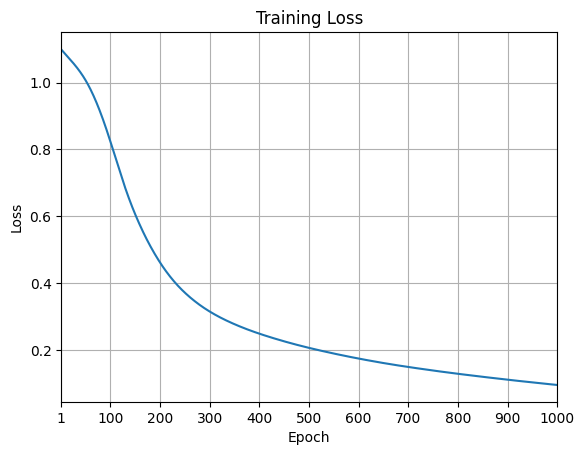

In [56]:
# Visualization of training loss over epochs
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.xticks([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(1, 1000)
plt.grid()
plt.show()

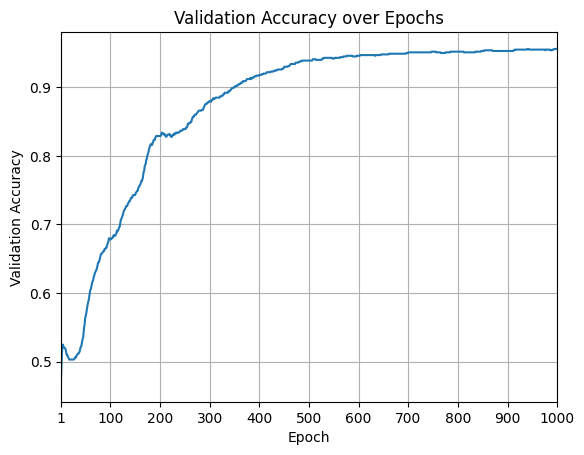

In [57]:
#Visualization of validation accuracy over epochs
plt.plot(range(epochs), val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xticks([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(1, 1000)
plt.grid()
plt.show()

## Evaluation

In [58]:
# Classification Report
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred_test, dim=1)

# OUTPUT FOR CPU TESTING
# print("Classification Report:\n")
# print(classification_report(y_test_tensor.numpy(), y_pred_labels.numpy(), target_names=["N", "VEB", "SVEB"]))

# OUTPUT FOR GPU TESTING
print("Classification Report:\n")
print(classification_report(
    y_test_tensor.cpu().numpy(),  # move to CPU before .numpy()
    y_pred_labels.cpu().numpy(),  # move to CPU before .numpy()
    target_names=["N", "VEB", "SVEB"]
))

Classification Report:

              precision    recall  f1-score   support

           N       0.97      0.97      0.97       500
         VEB       0.98      0.97      0.97       250
        SVEB       0.92      0.93      0.93       250

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [59]:
# Accuracy
accuracy = (y_pred_labels == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9590


# **Prediction Application**
Legend:


*   0: Normal (N)
*   1: Ventricular Ectopic Beat (VEB)
*   2: Supraventricular Ectopic Beat (SVEB)

## Load Dataset.

In [60]:
# Recall...
default_rows = len(df_balanced)
print("Default Row Count:", default_rows)

#remove F and Q types and reconfirm row count
df_balanced = df_balanced[df_balanced['type'].isin(["N", "VEB", "SVEB"])]
filtered_rows = len(df_balanced)
print("Row Count Excluding F and Q:", filtered_rows)
print("Rows Removed:", default_rows - filtered_rows, "\n")
print(df_balanced.head())

Default Row Count: 10000
Row Count Excluding F and Q: 10000
Rows Removed: 0 

   record type  0_pre-RR  0_post-RR   0_pPeak   0_tPeak   0_rPeak   0_sPeak  \
0     200  VEB       204        193  0.072093  0.981791 -1.017812 -1.710520   
1     215    N       199        194  0.030454  0.922415  0.892082  0.892082   
2     209    N       228        230 -0.007364  1.056083  1.020817  1.020817   
3     119    N       340        341 -0.051494 -0.373309  1.793418 -0.825145   
4     203    N       223        254 -0.020287  0.233794  1.196078 -0.985120   

    0_qPeak  0_qrs_interval  ...   1_qPeak  1_qrs_interval  1_pq_interval  \
0 -1.017812               5  ... -0.137798              16             22   
1  0.028786              21  ... -0.001023              10              2   
2 -0.046637              10  ...  0.025466              23              6   
3 -0.060406              24  ...  0.000257              21              1   
4 -0.083647              55  ... -0.151553               8    

In [61]:
# Load the scaler
scaler = joblib.load("scaler.pkl")
print("Pulling saved scaler.pkl from session path...")

Pulling saved scaler.pkl from session path...


## Mean Calculations for Essential Features.


In [62]:
# printing all attributes (32)
prediction_features = X.columns.tolist()
prediction_features

['0_pre-RR',
 '0_post-RR',
 '0_pPeak',
 '0_tPeak',
 '0_rPeak',
 '0_sPeak',
 '0_qPeak',
 '0_qrs_interval',
 '0_pq_interval',
 '0_qt_interval',
 '0_st_interval',
 '0_qrs_morph0',
 '0_qrs_morph1',
 '0_qrs_morph2',
 '0_qrs_morph3',
 '0_qrs_morph4',
 '1_pre-RR',
 '1_post-RR',
 '1_pPeak',
 '1_tPeak',
 '1_rPeak',
 '1_sPeak',
 '1_qPeak',
 '1_qrs_interval',
 '1_pq_interval',
 '1_qt_interval',
 '1_st_interval',
 '1_qrs_morph0',
 '1_qrs_morph1',
 '1_qrs_morph2',
 '1_qrs_morph3',
 '1_qrs_morph4']

In [63]:
# showing means for each type (for our reference)
print("\n [Per class means for each feature]\n")
classwise_means = df.groupby("type")[prediction_features].mean().round(2)
classwise_means.index = classwise_means.index.map({0: "N", 1: "VEB", 2: "SVEB"})
display(classwise_means)


 [Per class means for each feature]



,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
type,,,,,,,,,,,,,,,,,,,,,
N,287.21,275.97,0.04,0.36,1.09,-0.07,-0.08,27.82,10.68,57.76,...,-0.30,11.03,9.69,34.54,13.82,-0.30,-0.30,-0.29,-0.26,-0.34
VEB,185.06,307.18,0.24,0.52,0.52,-1.09,-0.30,37.25,18.26,95.85,...,-0.48,13.99,19.28,53.78,20.51,-0.48,-0.45,-0.42,-0.43,-0.48
SVEB,218.76,310.24,0.05,0.49,0.69,0.24,-0.03,23.03,8.91,40.47,...,-0.16,13.25,8.87,34.57,12.45,-0.16,-0.15,-0.15,-0.19,-0.31


In [64]:
# save as .csv
df_means = pd.concat([classwise_means])
output_path1 = "classwise_means1.csv"
df_means.to_csv(output_path1, index = False)

print("Uploading", output_path1, "to session path...")

Uploading classwise_means1.csv to session path...


In [65]:
# Combine into balanced subset
df_test = df_balanced.drop(columns=["record", "type"])  #independent features

# save as .csv
# output_path = "balanced_dataset.csv" #1
X = df.drop(columns=["record", "type"])  #independent features
output_path2 = "test_dataset.csv"
df_test.to_csv(output_path2, index = False)

print("Uploading", output_path2, "to session path...")

Uploading test_dataset.csv to session path...


## Predictor Manual Accuracy Test.
Legend:


*   0: Normal (N)
*   1: Ventricular Ectopic Beat (VEB)
*   2: Supraventricular Ectopic Beat (SVEB)

In [66]:
# ZIQI'S TESTING

# Load your CSV containing new observations
# input_df = pd.read_csv(output_path)
input_df = pd.read_csv(output_path2)

# Load scaler and model (already trained)
scaler = joblib.load("scaler.pkl")
model.eval()

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make sure your feature list matches the columns in input_df
# e.g. if you dropped 2 columns, prediction_features should be length 30 now
prediction_features = [col for col in prediction_features if col in input_df.columns]


for idx, (_, row) in enumerate(input_df.iterrows()):
    if idx >= 500:
        break

    # Build a one‐row DataFrame with EXACTLY the same column names as the scaler expects
    user_input_df = pd.DataFrame([row[prediction_features]], columns=prediction_features)

    # Now transform using the scaler (no warning, names line up)
    user_input_scaled = scaler.transform(user_input_df)

    # Convert to tensor and send to device
    user_tensor = torch.tensor(user_input_scaled, dtype=torch.float32).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(user_tensor)
        prediction = torch.argmax(output, dim=1).item()

    print(f"Row {idx+1} → Predicted arrhythmia type: {prediction}")

Row 1 → Predicted arrhythmia type: 1
Row 2 → Predicted arrhythmia type: 0
Row 3 → Predicted arrhythmia type: 0
Row 4 → Predicted arrhythmia type: 0
Row 5 → Predicted arrhythmia type: 0
Row 6 → Predicted arrhythmia type: 1
Row 7 → Predicted arrhythmia type: 0
Row 8 → Predicted arrhythmia type: 1
Row 9 → Predicted arrhythmia type: 1
Row 10 → Predicted arrhythmia type: 0
Row 11 → Predicted arrhythmia type: 0
Row 12 → Predicted arrhythmia type: 1
Row 13 → Predicted arrhythmia type: 1
Row 14 → Predicted arrhythmia type: 1
Row 15 → Predicted arrhythmia type: 0
Row 16 → Predicted arrhythmia type: 1
Row 17 → Predicted arrhythmia type: 0
Row 18 → Predicted arrhythmia type: 2
Row 19 → Predicted arrhythmia type: 1
Row 20 → Predicted arrhythmia type: 2
Row 21 → Predicted arrhythmia type: 2
Row 22 → Predicted arrhythmia type: 0
Row 23 → Predicted arrhythmia type: 0
Row 24 → Predicted arrhythmia type: 2
Row 25 → Predicted arrhythmia type: 0
Row 26 → Predicted arrhythmia type: 2
Row 27 → Predicted ar

## User Input for Predictor.

In [67]:
# ask user whether to use mean values (default) or manually input
  # if yes -> automatcally using default mean values (Majority N)
  # no -> manually enter 32 features

use_means = input("Use default mean values (calculated by computer)? \nNote: if yes, computer will calculate mean values for all types and use them as input. (yes/no): ").lower() == "yes"

# whatever values that are collected (either manually/default means) store them in the list
user_input = []

# Input loop
if use_means:
  # calculate the overall mean for each of the features
    feature_means = {col: df[col].mean() for col in prediction_features}
    print("\n Using the following mean values for prediction:\n")
    for feat, mean_val in feature_means.items():
        print(f"{feat}: {mean_val:.4f}")

  # save mean values as user input
    user_input = [feature_means[feat] for feat in prediction_features]

else:
  # manually enter values by user
    for feature in prediction_features:
        val = float(input(f"Enter value for {feature}: "))
        user_input.append(val)

Use default mean values (calculated by computer)? 
Note: if yes, computer will calculate mean values for all types and use them as input. (yes/no): no
Enter value for 0_pre-RR: 218.76
Enter value for 0_post-RR: 310.24
Enter value for 0_pPeak: 0.05
Enter value for 0_tPeak: 0.49
Enter value for 0_rPeak: 0.69
Enter value for 0_sPeak: 0.24
Enter value for 0_qPeak: -0.03
Enter value for 0_qrs_interval: 23.03
Enter value for 0_pq_interval: 8.91
Enter value for 0_qt_interval: 40.47
Enter value for 0_st_interval: 8.53
Enter value for 0_qrs_morph0: -0.03
Enter value for 0_qrs_morph1: 0
Enter value for 0_qrs_morph2: 0.12
Enter value for 0_qrs_morph3: 0.24
Enter value for 0_qrs_morph4: 0.25
Enter value for 1_pre-RR: 218.76
Enter value for 1_post-RR: 310.24
Enter value for 1_pPeak: 0.01
Enter value for 1_tPeak: 0.33
Enter value for 1_rPeak: -0.09
Enter value for 1_sPeak: -0.42
Enter value for 1_qPeak: -0.16
Enter value for 1_qrs_interval: 13.25
Enter value for 1_pq_interval: 8.87
Enter value for 1

In [68]:
# sanity check for user input dims (seems to glitch sometimes)
print("Dimensions of Input (should be 32):", len(user_input)) # <- MUST BE 32

Dimensions of Input (should be 32): 32


In [69]:
# normalize user input using scalar (identical to training)
user_input_np = np.array(user_input).reshape(1, -1)
user_input_scaled = scaler.transform(user_input_np)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [70]:
# Change to PyTorch tensor
user_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)

# TO GPU
user_tensor = user_tensor.to(device)  # <- Move it to CUDA if available

## Predictor Model.
Legend:


*   0: Normal (N)
*   1: Ventricular Ectopic Beat (VEB)
*   2: Supraventricular Ectopic Beat (SVEB)

In [71]:
#JULIE'S PREDICTOR
model.eval()
with torch.no_grad():
    output = model(user_tensor)
    prediction = torch.argmax(output, dim=1).item()

# predicting (GPU)
user_tensor = user_tensor.to(device)  # ensure it's on same device as model
model.eval()
with torch.no_grad():
    output = model(user_tensor)
    prediction = torch.argmax(output, dim=1).item()

print(f"Predicted arrhythmia type: {prediction}")

Predicted arrhythmia type: 2
